In [ ]:
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt
drive.mount("/content/drive",force_remount=True)
INPUT_FILEBASE = "/content/drive/MyDrive/yelp_dataset_in/"
OUTPUT_FILEBASE = "/content/drive/MyDrive/yelp_dataset_out/"

Mounted at /content/drive


In [ ]:
business = pd.read_json('%syelp_academic_dataset_business.json' %INPUT_FILEBASE, lines=True)
business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
business['categories'].unique()
# print(business['categories'].unique())
# 1 = open, 0 = closed
business = business[business['is_open']==1]
drop_columns = ['hours','is_open','review_count']
business = business.drop(drop_columns, axis=1)
business_etx = business[business['categories'].str.contains(
              'Laptop|Desktop|PCs|Electronics|Mobiles',
              case=False, na=False)]

In [ ]:
# assert False # this takes long time to execute
size = 1000000
review = pd.read_json("%syelp_academic_dataset_review.json" %INPUT_FILEBASE, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)
# There are multiple chunks to be read
chunk_list = []
for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['useful','funny','cool'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(business_etx, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

4371 out of 1,000,000 related reviews
5108 out of 1,000,000 related reviews
5756 out of 1,000,000 related reviews
5779 out of 1,000,000 related reviews
5033 out of 1,000,000 related reviews
4717 out of 1,000,000 related reviews
6093 out of 1,000,000 related reviews


In [ ]:
csv_name = "yelp_reviews_Electronics_categories.csv"
df.to_csv("%s%s" %(OUTPUT_FILEBASE,csv_name), index=False)

In [ ]:
# because this file has review_id also added which we can use later on if required to link it with the main dataset
csv_name = "yelp_reviews_Electronics_categories1.csv"
data = pd.read_csv("%s%s" %(OUTPUT_FILEBASE,csv_name))

In [ ]:
df = data[["review_id","text"]].copy()
df.rename(columns={"text":"review"},inplace=True)
df.head()

,review_id,review
0,oGrpLurDvwrrgi4IQktmJg,I usually love going to this t-mobile. The rep...
1,B5QI7QaJBv_kDLGlxU3f4w,The store gave me misleading information. One...
2,xWypPMQgQQyye1XHTf5XPQ,"Nice, stand-alone T-Mobile in the parking lot ..."
3,xYPLlii344djCx5fJ2tZRw,I get awesome service every time I come here. ...
4,IMdRCuE2CluGMsVdL7RARg,Very busy I waited for 45 min before even bein...


**Exploratory data analysis**





In [ ]:
df['review_word_count'] = df['review'].apply(lambda x: len(str(x).split()))
df['review_char_count'] = df['review'].apply(lambda x: len(str(x)))
df.head()

,review_id,review,review_word_count,review_char_count
0,oGrpLurDvwrrgi4IQktmJg,I usually love going to this t-mobile. The rep...,55,290
1,B5QI7QaJBv_kDLGlxU3f4w,The store gave me misleading information. One...,200,1076
2,xWypPMQgQQyye1XHTf5XPQ,"Nice, stand-alone T-Mobile in the parking lot ...",23,136
3,xYPLlii344djCx5fJ2tZRw,I get awesome service every time I come here. ...,20,109
4,IMdRCuE2CluGMsVdL7RARg,Very busy I waited for 45 min before even bein...,17,86


Text(0, 0.5, 'Number of Words')

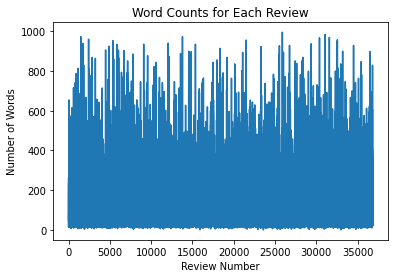

In [ ]:
df['review_word_count'].plot()
plt.title('Word Counts for Each Review')
plt.xlabel('Review Number')
plt.ylabel('Number of Words')

In [ ]:
df = df[df['review_word_count'] < 300]
df.shape

(34811, 4)

**Data pre-processing using natural language processing**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-9-c3667d58f092>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaned'] = df['lower_case'].str.replace('[^\w\s]', '')


Text(0, 0.5, 'Number of Words')

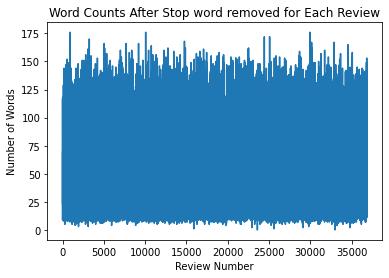

In [ ]:
# Removing Stop Words
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df['lower_case'] = df['review'].apply(lambda x: ' '.join(word.lower() for word in str(x).split()))
df['cleaned'] = df['lower_case'].str.replace('[^\w\s]', '')
df['review_stopwords_removed'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['review_word_count_after_stop_words_removed'] = df['review_stopwords_removed'].apply(lambda x: len(str(x).split()))
df['review_word_count_after_stop_words_removed'].plot()
plt.title('Word Counts After Stop word removed for Each Review')
plt.xlabel('Review Number')
plt.ylabel('Number of Words')

In [ ]:
df.head()

,review_id,review,review_word_count,review_char_count,lower_case,cleaned,review_stopwords_removed,review_word_count_after_stop_words_removed
0,oGrpLurDvwrrgi4IQktmJg,I usually love going to this t-mobile. The rep...,55,290,i usually love going to this t-mobile. the rep...,i usually love going to this tmobile the repre...,usually love going tmobile representatives alw...,24
1,B5QI7QaJBv_kDLGlxU3f4w,The store gave me misleading information. One...,200,1076,the store gave me misleading information. one ...,the store gave me misleading information one o...,store gave misleading information one represen...,93
2,xWypPMQgQQyye1XHTf5XPQ,"Nice, stand-alone T-Mobile in the parking lot ...",23,136,"nice, stand-alone t-mobile in the parking lot ...",nice standalone tmobile in the parking lot of ...,nice standalone tmobile parking lot concord ma...,13
3,xYPLlii344djCx5fJ2tZRw,I get awesome service every time I come here. ...,20,109,i get awesome service every time i come here. ...,i get awesome service every time i come here t...,get awesome service every time come thing get ...,13
4,IMdRCuE2CluGMsVdL7RARg,Very busy I waited for 45 min before even bein...,17,86,very busy i waited for 45 min before even bein...,very busy i waited for 45 min before even bein...,busy waited 45 min even able helped would reco...,9


In [ ]:
pd.Series(''.join(df['review_stopwords_removed']).split()).value_counts()[:20] # to do remove if required later on
# do word cloud if required
# this is to remove the redundant words

store       18115
service     14269
phone       12980
get         11910
one         11158
would       10515
time         9920
customer     9271
back         9014
go           8349
new          8155
like         8014
great        7519
even         6703
dont         6558
walmart      6409
told         6324
said         6072
screen       5980
went         5802
dtype: int64

In [ ]:
# stemming and lemmatization
import textblob
from textblob import Word
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer(language='english')
def stemmer(text):
  wordList = nltk.word_tokenize(text)
  stemWords = [snow_stemmer.stem(word) for word in wordList]
  return ' '.join(stemWords)
df['lemmatized'] = df['review_stopwords_removed'].apply(lambda x: ' '.join(Word(word).lemmatize() for word in x.split()))
df['stemmed'] = df.lemmatized.apply(stemmer)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review_id,review,review_word_count,review_char_count,lower_case,cleaned,review_stopwords_removed,review_word_count_after_stop_words_removed,lemmatized,stemmed
0,oGrpLurDvwrrgi4IQktmJg,I usually love going to this t-mobile. The rep...,55,290,i usually love going to this t-mobile. the rep...,i usually love going to this tmobile the repre...,usually love going tmobile representatives alw...,24,usually love going tmobile representative alwa...,usual love go tmobil repres alway nice help to...
1,B5QI7QaJBv_kDLGlxU3f4w,The store gave me misleading information. One...,200,1076,the store gave me misleading information. one ...,the store gave me misleading information one o...,store gave misleading information one represen...,93,store gave misleading information one represen...,store gave mislead inform one repres told id a...
2,xWypPMQgQQyye1XHTf5XPQ,"Nice, stand-alone T-Mobile in the parking lot ...",23,136,"nice, stand-alone t-mobile in the parking lot ...",nice standalone tmobile in the parking lot of ...,nice standalone tmobile parking lot concord ma...,13,nice standalone tmobile parking lot concord ma...,nice standalon tmobil park lot concord mall iv...
3,xYPLlii344djCx5fJ2tZRw,I get awesome service every time I come here. ...,20,109,i get awesome service every time i come here. ...,i get awesome service every time i come here t...,get awesome service every time come thing get ...,13,get awesome service every time come thing get ...,get awesom servic everi time come thing get pr...
4,IMdRCuE2CluGMsVdL7RARg,Very busy I waited for 45 min before even bein...,17,86,very busy i waited for 45 min before even bein...,very busy i waited for 45 min before even bein...,busy waited 45 min even able helped would reco...,9,busy waited 45 min even able helped would reco...,busi wait 45 min even abl help would recommend


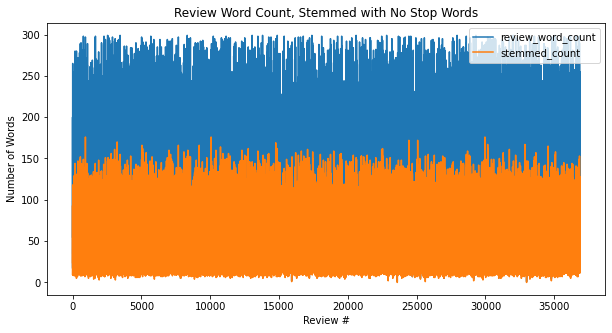

In [ ]:
df['stemmed_count'] = df['stemmed'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
df['review_word_count'].plot()
df["stemmed_count"].plot()
plt.title('Review Word Count, Stemmed with No Stop Words')
plt.xlabel('Review #')
plt.ylabel('Number of Words')
plt.legend()

**Polarity and Subjectivity. This will be used to classify review text in four classes** 

In [ ]:
from textblob import TextBlob
# Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling. Hence we use lemma.. coz it preserves the context of the word
df['polarity'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])
df.head()

,review_id,review,review_word_count,review_char_count,lower_case,cleaned,review_stopwords_removed,review_word_count_after_stop_words_removed,lemmatized,stemmed,stemmed_count,polarity,subjectivity
0,oGrpLurDvwrrgi4IQktmJg,I usually love going to this t-mobile. The rep...,55,290,i usually love going to this t-mobile. the rep...,i usually love going to this tmobile the repre...,usually love going tmobile representatives alw...,24,usually love going tmobile representative alwa...,usual love go tmobil repres alway nice help to...,24,0.207273,0.644242
1,B5QI7QaJBv_kDLGlxU3f4w,The store gave me misleading information. One...,200,1076,the store gave me misleading information. one ...,the store gave me misleading information one o...,store gave misleading information one represen...,93,store gave misleading information one represen...,store gave mislead inform one repres told id a...,93,0.019444,0.666667
2,xWypPMQgQQyye1XHTf5XPQ,"Nice, stand-alone T-Mobile in the parking lot ...",23,136,"nice, stand-alone t-mobile in the parking lot ...",nice standalone tmobile in the parking lot of ...,nice standalone tmobile parking lot concord ma...,13,nice standalone tmobile parking lot concord ma...,nice standalon tmobil park lot concord mall iv...,13,0.433333,0.700000
3,xYPLlii344djCx5fJ2tZRw,I get awesome service every time I come here. ...,20,109,i get awesome service every time i come here. ...,i get awesome service every time i come here t...,get awesome service every time come thing get ...,13,get awesome service every time come thing get ...,get awesom servic everi time come thing get pr...,13,0.221875,0.771875
4,IMdRCuE2CluGMsVdL7RARg,Very busy I waited for 45 min before even bein...,17,86,very busy i waited for 45 min before even bein...,very busy i waited for 45 min before even bein...,busy waited 45 min even able helped would reco...,9,busy waited 45 min even able helped would reco...,busi wait 45 min even abl help would recommend,9,0.300000,0.462500


**Adding Sentiment Class**

In [ ]:
df = df[df['polarity'] != 0]
df = df.reset_index()
sentiment = []
for i in range(len(df)):
    if df['polarity'][i] >= 0.4:
        sentiment.append('Positive')
    if df['polarity'][i] >= 0.2 and df['polarity'][i] < 0.4:
        sentiment.append('Slightly Positive')
    if df['polarity'][i] >= 0.1 and df['polarity'][i] < 0.2:
        sentiment.append('Neutral')
    if df['polarity'][i] >= -0.1 and df['polarity'][i] < 0.1:
        sentiment.append('Slightly Negative')
    if df['polarity'][i] < -0.1:
        sentiment.append('Negative')
df['sentiment'] = sentiment
df = df[df["sentiment"]!="Neutral"]
print(df.shape,df['sentiment'].unique())

(28001, 15) ['Slightly Positive' 'Slightly Negative' 'Positive' 'Negative']


In [ ]:
# sentiment = []
# for i in range(len(yelp_data_s)):
#     if yelp_data_s['Polarity'][i] >= 0.4:
#         sentiment.append('Positive')
#     if yelp_data_s['Polarity'][i] > 0.2 and yelp_data_s['Polarity'][i] < 0.4:
#         sentiment.append('Slightly Positive')
#     if yelp_data_s['Polarity'][i] <= 0.2 and yelp_data_s['Polarity'][i] > 0:
#         sentiment.append('Slightly Negative')
#     if yelp_data_s['Polarity'][i] < 0:
#         sentiment.append('Negative')
# yelp_data_s['sentiment'] = sentiment
# print(df['sentiment'].unique())

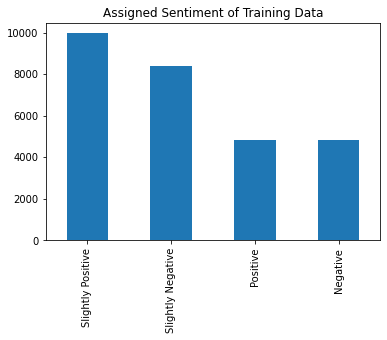

In [ ]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Assigned Sentiment of Training Data');

In [ ]:
csv_name = "yelp_reviews_Electronics_categories_sentiment.csv"
df[["review","lemmatized","stemmed","polarity","subjectivity","sentiment"]].to_csv("%s%s" %(OUTPUT_FILEBASE,csv_name), index=False)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
csv_name = "yelp_reviews_Electronics_categories_sentiment.csv"
df = pd.read_csv("%s%s" %(OUTPUT_FILEBASE,csv_name))
df = df[:10000]
# df[df["sentiment"]=="Neutral"]
text = df['stemmed']
print(df.shape,df["sentiment"].unique(),"A")
Tvectorizer = TfidfVectorizer()
Tvectorizer.fit(text)
Tvector = Tvectorizer.transform(text)
voc = Tvectorizer.vocabulary_
print(len(voc),'no of columns')
# assert False
df1 = pd.DataFrame(Tvector.toarray(),columns=voc)

# col_name1 ='Name'
col_name2 = 'review_'
col_name3 = 'polarity'
col_name4 = 'sentiment_'
# col_name5 = 'Positive_Words_P'

# col1 = df['Name']
col2 = df['review']
col3 = df['polarity']
col4 = df['sentiment']
# col5 = df['Positive_Words_P']
print(col4.unique(),"XX")
# df1.insert(0,col_name1,col1)
df1.insert(1,col_name2,col2)
df1.insert(2,col_name3,col3)
df1.insert(3,col_name4,col4)
df1.head()
print(df1.shape,df1["sentiment"].unique())
pickle_name = "yelp_reviews_Electronics_categories_final.pickle"
df1.to_pickle("%s%s" %(OUTPUT_FILEBASE,pickle_name))
# csv_name = "yelp_reviews_Electronics_categories_final.csv"
# df1.to_csv("%s%s" %(OUTPUT_FILEBASE,csv_name), index=False)
# df1.insert(4,col_name5,col5)
# Model building in different notebooki

(10000, 6) ['Slightly Positive' 'Slightly Negative' 'Positive' 'Negative'] A
17610 no of columns
['Slightly Positive' 'Slightly Negative' 'Positive' 'Negative'] XX
(10000, 17613) [0.         0.35065952]
